# Airline efficiencies

In [1]:
import numpy as np
from scipy.optimize import curve_fit, minimize
from scipy import stats
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from cmocean import cm as cmo
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors

In [2]:
airlines = pd.read_csv("../data/by_airline.csv")
airlines

,airlinename,aircraft_types,avg_distance,flown_distance,gcd,flights,passengers,seats,rpk,average_load,co2,gco2_pax_km
0,American Airlines,17,1441.229607,2.884425e+09,2.707591e+09,2001364,2.002134e+08,250847447,3.483689e+11,0.808484,3.374685e+07,96.871004
1,Delta Air Lines,26,1611.532357,2.534523e+09,2.393897e+09,1572741,1.661685e+08,221545212,3.260739e+11,0.760653,3.426087e+07,105.070860
2,Ryanair,2,1329.030003,1.095810e+09,1.019051e+09,824519,1.455875e+08,155473623,1.934996e+11,0.936413,1.349324e+07,69.732657
3,United Airlines,21,1916.810506,2.681953e+09,2.553278e+09,1399175,1.429037e+08,183750484,3.567485e+11,0.786006,3.299740e+07,92.494857
4,China Southern Airlines,16,1442.779854,1.196884e+09,1.117051e+09,829568,1.112029e+08,145227075,1.643527e+11,0.765671,1.408231e+07,85.683459
...,...,...,...,...,...,...,...,...,...,...,...,...
585,Equaflight,1,428.831645,1.286495e+04,1.136495e+04,30,8.714212e+02,1110,3.736930e+05,0.785064,8.844925e+01,236.689622
586,Eastern Airlines,2,3185.842995,2.548674e+04,2.468674e+04,8,8.656065e+02,1808,2.752805e+06,0.480707,4.398076e+02,159.767106
587,Fly Mid Africa,2,1240.115502,7.440693e+03,6.840693e+03,6,8.620004e+02,1098,1.068980e+06,0.785064,8.879028e+01,83.060745
588,Wamos Air S.A.,1,6702.976358,1.340595e+04,1.315595e+04,2,6.031871e+02,750,4.043149e+06,0.804250,3.318736e+02,82.082939


In [3]:
intensity = np.array(airlines['gco2_pax_km'])
co2 = np.array(airlines['co2'])
load = np.array(airlines['average_load'])

In [4]:
order = np.argsort(co2)
intensity = intensity[order]
co2 = co2[order]
load = load[order]

In [5]:

def f1(x, a, b):
    return a * np.log10(x) + b

def f2(x, a, b):
    return a * x + b

p1, _ = curve_fit(f1, co2, intensity)
p2, _ = curve_fit(f2, load, intensity)


In [15]:
N = 1000                          # bootstrap that many times
nsamples = len(airlines) // 2     # using 50% of the airlines
m = 100                           # evaluate on that many points

co2_fit_samples = np.zeros((N, m))
load_fit_samples = np.zeros((N, m))

x1 = np.logspace(1, 8, m)
x2 = np.linspace(0, 1, m)

for k in range(N):

    # random sample
    o = np.arange(len(airlines))
    np.random.shuffle(o)
    sample = o[:nsamples]

    # predictors
    co2_sample = co2[sample]
    load_sample = load[sample]
    
    # predictand
    i_sample = intensity[sample]

    popt_co2_sample, _ = curve_fit(f1, co2_sample, i_sample)
    popt_load_sample, _ = curve_fit(f2, load_sample, i_sample)

    co2_fit_samples[k, :] = f1(x1, *popt_co2_sample)
    load_fit_samples[k, :] = f2(x2, *popt_load_sample)

co2_fit_p5 = np.percentile(co2_fit_samples, 5, axis=0)
co2_fit_p95 = np.percentile(co2_fit_samples, 95, axis=0)

load_fit_p5 = np.percentile(load_fit_samples, 5, axis=0)
load_fit_p95 = np.percentile(load_fit_samples, 95, axis=0)

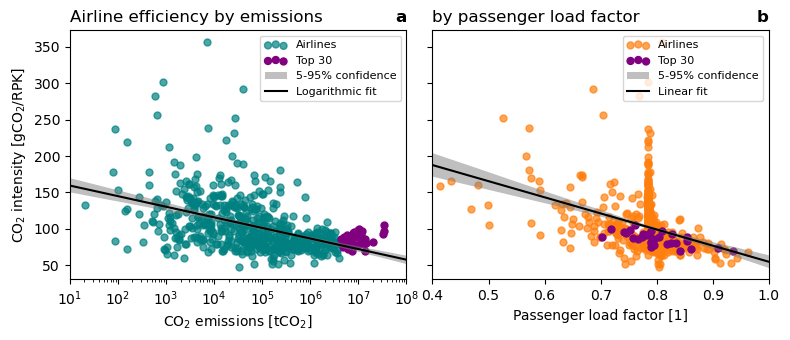

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3.5), sharey=True)

ax1.set_xscale('log')

ax1.scatter(co2[:-30], intensity[:-30], 25, color="teal", alpha=0.7, label="Airlines")
ax2.scatter(load[:-30], intensity[:-30], 25, color="C1", alpha=0.7, label="Airlines")

# 30 highest emitting airlines
ax1.scatter(co2[-30:], intensity[-30:], 25, color="purple", alpha=1, label="Top 30")
ax2.scatter(load[-30:], intensity[-30:], 25, color="purple", alpha=1, label="Top 30")

ax1.fill_between(x1, co2_fit_p5, co2_fit_p95, facecolor='grey', alpha=0.5, zorder=2, label="5-95% confidence")
ax2.fill_between(x2, load_fit_p5, load_fit_p95, facecolor='grey', alpha=0.5, zorder=2, label="5-95% confidence")

y1 = f1(x1, *p1)
y2 = f2(x2, *p2)

ax1.plot(x1, y1, "k", label="Logarithmic fit")
ax2.plot(x2, y2, "k", label="Linear fit")

ax1.legend(scatterpoints=3, loc='upper right', fontsize=8)
ax2.legend(scatterpoints=3, loc='upper right', fontsize=8)

ax1.set_xlabel('CO$_2$ emissions [tCO$_2$]')
ax2.set_xlabel('Passenger load factor [1]')
ax1.set_ylabel('CO$_2$ intensity [gCO$_2$/RPK]')
ax1.set_title('Airline efficiency by emissions', loc='left')
ax2.set_title('by passenger load factor', loc='left')
ax1.set_title('a', loc='right', fontweight='bold')
ax2.set_title('b', loc='right', fontweight='bold')

ax1.set_xlim(1e1, 1e8)
ax2.set_xlim(0.4, 1)

plt.tight_layout()
plt.show()